<a href="https://colab.research.google.com/github/zbates1/Owens-Lab-RNASeq/blob/main/Final_RNA_Seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

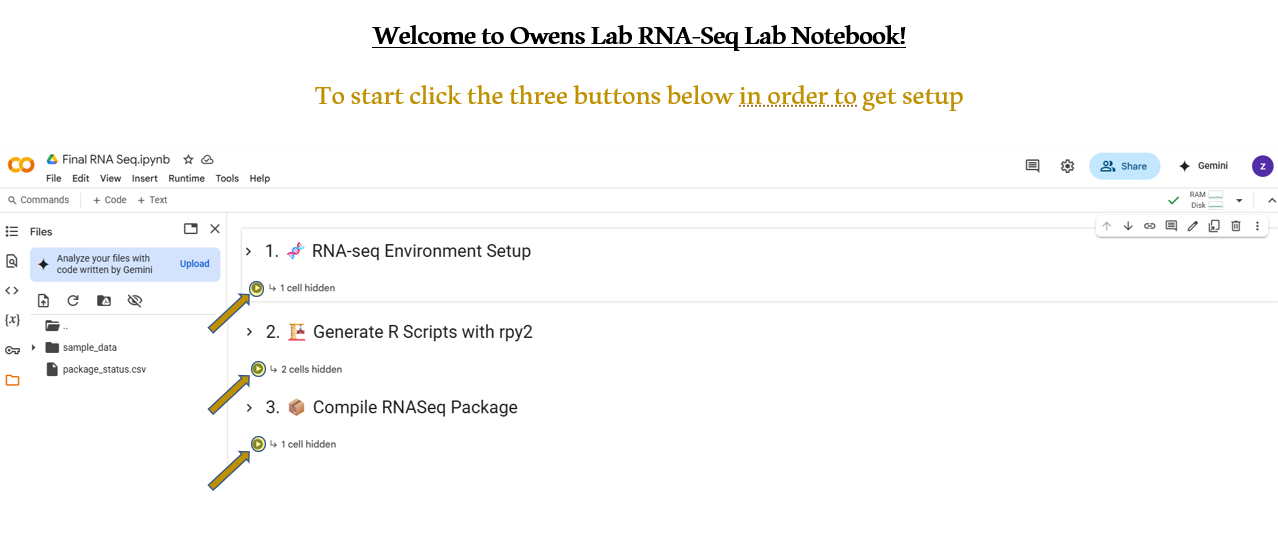

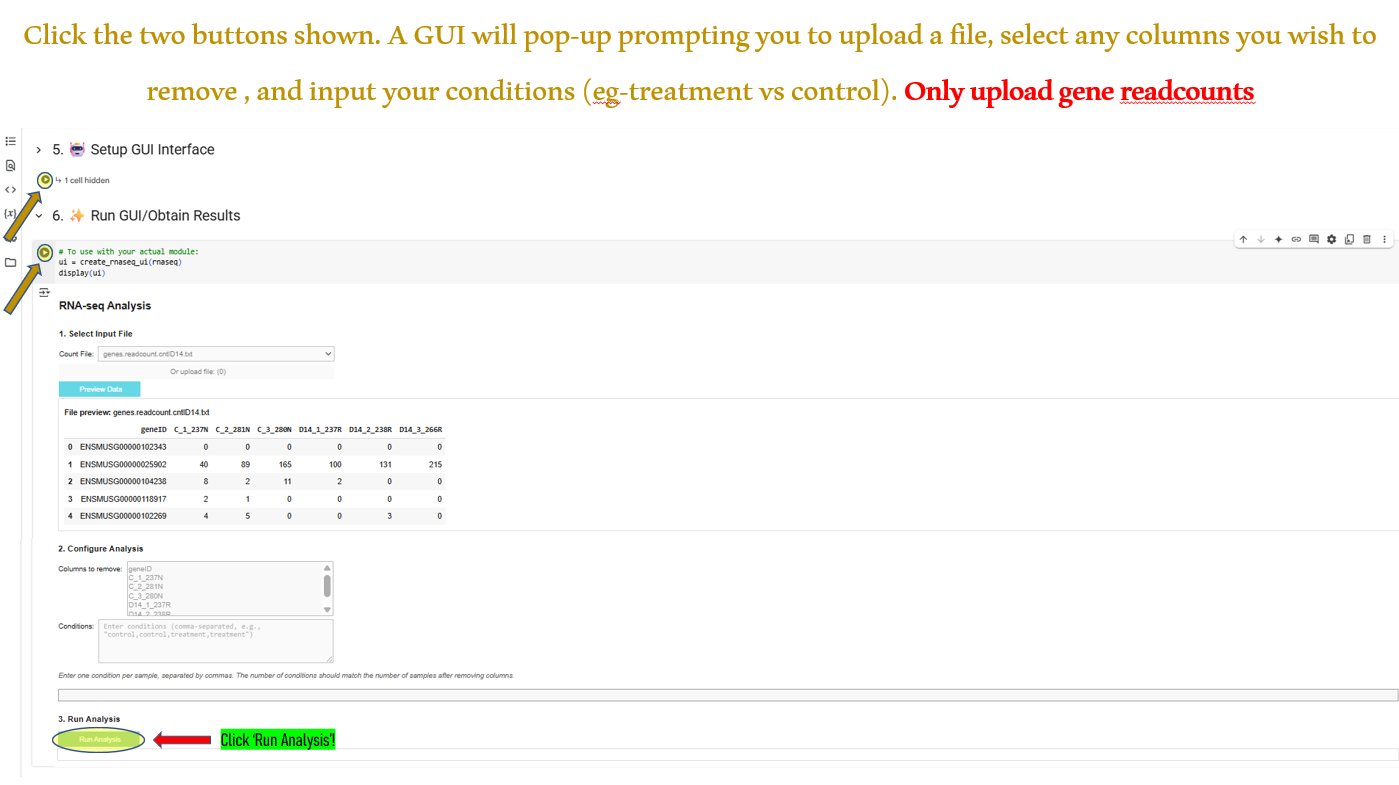

# 1. 🧬 RNA-seq Environment Setup

---

In [ ]:
# setup_colab_environment.py
import os
import sys
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
import pandas as pd

def setup_colab_environment():
    """Set up the RNA-seq analysis environment in Google Colab"""
    print("🛠️ Setting up environment...")

    # 1. Install system dependencies
    print("\n1️⃣ Installing system dependencies...")
    try:
        !sudo apt-get update -qq
        !sudo apt-get install -y --no-install-recommends \
            libfreetype6-dev \
            libpng-dev \
            libtiff5-dev \
            libjpeg-dev \
            r-base \
            r-base-dev > /dev/null 2>&1
        print("✓ System dependencies installed")
    except Exception as e:
        print(f"⚠️ System dependency installation warning: {str(e)}")

    # 2. Configure R options
    print("\n2️⃣ Configuring R...")
    ro.r('options(repos = c(CRAN = "https://cloud.r-project.org"))')
    ro.r('options(install.packages.compile.from.source = "never")')
    ro.r('options(Ncpus = 2)')  # Use 2 cores for installation
    print("✓ R configured")

    # 3. Install CRAN packages with individual error handling
    print("\n3️⃣ Installing CRAN packages...")
    cran_packages = [
        "tidyverse",
        "pheatmap",
        "here",
        "BiocManager"
    ]

    # Add this after installing the CRAN packages 0-----------------> NEW
    print("\n3️⃣.1 Reinstalling potentially problematic packages...")
    try:
        !Rscript -e "install.packages('grid', repos='https://cloud.r-project.org')"
        !Rscript -e "install.packages('ggplot2', repos='https://cloud.r-project.org')"
        print("✓ Reinstalled grid and ggplot2")
    except Exception as e:
        print(f"⚠️ Warning during reinstallation: {str(e)}")
    # Add this after installing the CRAN packages 0-----------------> NEW


    for pkg in cran_packages:
        print(f"• Installing {pkg}...")
        try:
            !Rscript -e "if (!requireNamespace('{pkg}', quietly = TRUE)) install.packages('{pkg}', repos='https://cloud.r-project.org', Ncpus=2)"
        except:
            print(f"⚠️  Failed to install {pkg}, trying alternative method...")
            !R -e "if (!requireNamespace('{pkg}', quietly = TRUE)) install.packages('{pkg}', repos='https://cloud.r-project.org')"

    # 4. Install Bioconductor packages with robust error handling
    print("\n4️⃣ Installing Bioconductor packages...")
    bioc_packages = [
        "DESeq2",
        "org.Mm.eg.db",
        "clusterProfiler",
        "biomaRt",
        "enrichplot"
    ]

    # First ensure BiocManager is installed
    !Rscript -e "if (!requireNamespace('BiocManager', quietly = TRUE)) install.packages('BiocManager', repos='https://cloud.r-project.org')"

    for pkg in bioc_packages:
        print(f"• Installing {pkg}...")
        max_retries = 2
        for attempt in range(max_retries):
            try:
                !Rscript -e "if (!requireNamespace('{pkg}', quietly = TRUE)) BiocManager::install('{pkg}', ask=FALSE, Ncpus=2, update=FALSE)"
                break
            except Exception as e:
                if attempt == max_retries - 1:
                    print(f"⚠️  Failed to install {pkg} after {max_retries} attempts")
                else:
                    print(f"Retrying {pkg} installation...")

    # 5. Enhanced verification with improved detection
    print("\n✅ Verifying installations...")
    # Create a more reliable check for installed packages
    check_script = """
    packages <- c({})
    status <- sapply(packages, function(pkg) {{
        is_installed <- requireNamespace(pkg, quietly = TRUE)
        version <- if (is_installed) as.character(packageVersion(pkg)) else NA
        c(installed = is_installed, version = version)
    }})
    status_df <- data.frame(
        Package = colnames(status),
        Installed = as.logical(status["installed", ]),
        Version = status["version", ]
    )
    print(status_df)
    write.csv(status_df, file = "package_status.csv", row.names = FALSE)
    """

    # Format package list for R
    all_packages = cran_packages + bioc_packages
    package_str = ', '.join([f'"{pkg}"' for pkg in all_packages])

    # Run the check and capture output
    !Rscript -e '{check_script.format(package_str)}'

    # Process the results
    import pandas as pd
    import os

    if os.path.exists("package_status.csv"):
        pkg_status = pd.read_csv("package_status.csv")
        missing = pkg_status[~pkg_status['Installed']]['Package'].tolist()

        for _, row in pkg_status.iterrows():
            if row['Installed']:
                print(f"✓ {row['Package']} (v{row['Version']})")
            else:
                print(f"⚠️ {row['Package']} (missing)")

        if missing:
            print(f"\n❌ Missing packages: {', '.join(missing)}")
            print("\n💡 Try installing manually with:")
            for pkg in missing:
                if pkg in bioc_packages:
                    print(f"!Rscript -e \"BiocManager::install('{pkg}', ask=FALSE, force=TRUE)\"")
                else:
                    print(f"!Rscript -e \"install.packages('{pkg}', repos='https://cloud.r-project.org', force=TRUE)\"")
            return False
        else:
            print("\n🎉 All packages installed successfully!")
            return True
    else:
        print("\n❌ Failed to verify installations")
        return False

# Set up R script generator path
def ensure_r_script_generator():
    """Make sure we have access to the R script generator module"""
    # Check if the r_script_generator module is available
    try:
        from r_script_generator import create_convert_script, create_rnaseq_r_package
        return True
    except ImportError:
        print("R script generator module not found. Creating it...")
        try:
            # Get the current directory
            current_dir = os.getcwd()

            # Define the path for the r_script_generator.py file
            r_script_generator_path = os.path.join(current_dir, "r_script_generator.py")

            # Check if r_script_generator.py exists
            if not os.path.exists(r_script_generator_path):
                print(f"Creating R script generator module at {r_script_generator_path}")

                # Create module content
                # You would need to paste the content of r_script_generator.py here
                # For brevity, this is omitted
                print("Please run the cell that creates r_script_generator.py first.")
                return False
            else:
                print(f"R script generator module found at {r_script_generator_path}")
                # Add current directory to path if needed
                if current_dir not in sys.path:
                    sys.path.append(current_dir)
                return True
        except Exception as e:
            print(f"Error ensuring R script generator: {str(e)}")
            return False

if __name__ == "__main__":
    setup_complete = setup_colab_environment()
    r_script_available = ensure_r_script_generator()

    if setup_complete and r_script_available:
        from r_script_generator import create_convert_script
        create_convert_script()
        print("\n🎉 Environment is fully set up and ready for RNA-seq analysis!")
    else:
        print("\n⚠️ Some components could not be set up. Please check the warnings above.")


Streaming output truncated to the last 5000 lines.
/usr/local/lib/R/site-library/RcppEigen/include/Eigen/src/Householder/HouseholderSequence.h:399:46:   required from ‘void Eigen::HouseholderSequence<VectorsType, CoeffsType, Side>::applyThisOnTheLeft(Dest&, Workspace&, bool) const [with Dest = Eigen::Matrix<double, -1, -1>; Workspace = Eigen::Matrix<double, 1, -1>; VectorsType = Eigen::Matrix<double, -1, -1>; CoeffsType = Eigen::Matrix<double, -1, 1>; int Side = 1]’
/usr/local/lib/R/site-library/RcppEigen/include/Eigen/src/SVD/JacobiSVD.h:236:47:   required from ‘bool Eigen::internal::qr_preconditioner_impl<MatrixType, 2, 0, true>::run(Eigen::JacobiSVD<MatrixType, 2>&, const MatrixType&) [with MatrixType = Eigen::Matrix<double, -1, -1>]’
/usr/local/lib/R/site-library/RcppEigen/include/Eigen/src/SVD/JacobiSVD.h:692:30:   required from ‘Eigen::JacobiSVD<MatrixType, QRPreconditioner>& Eigen::JacobiSVD<MatrixType, QRPreconditioner>::compute(const MatrixType&, unsigned int) [with _MatrixTyp

# 2. 🏗️ Generate R Scripts with rpy2

---

In [ ]:
# r_script_generator.py

def create_convert_script(script_dir="scripts"):
    """Create the gene conversion script"""
    script_path = os.path.join(script_dir, "convert_gene_names.R")

    if not os.path.exists(script_dir):
        os.makedirs(script_dir)

    if not os.path.exists(script_path):
        script_content = """
        convert_ensembl_to_symbol <- function(data_frame, id_column) {
          if (!requireNamespace("biomaRt", quietly = TRUE)) {
            warning("biomaRt not available - using fallback conversion")
            data_frame$gene_symbol <- data_frame[[id_column]]
            data_frame$gene_description <- NA
            return(data_frame)
          }

          tryCatch({
            mart <- biomaRt::useMart("ensembl", dataset = "mmusculus_gene_ensembl")
            genes <- biomaRt::getBM(
              attributes = c("ensembl_gene_id", "external_gene_name", "description"),
              filters = "ensembl_gene_id",
              values = data_frame[[id_column]],
              mart = mart
            )

            merged <- merge(data_frame, genes,
                          by.x = id_column,
                          by.y = "ensembl_gene_id",
                          all.x = TRUE)
            return(merged)
          }, error = function(e) {
            warning("Gene conversion failed: ", e$message)
            data_frame$gene_symbol <- data_frame[[id_column]]
            data_frame$gene_description <- NA
            return(data_frame)
          })
        }
        """
        with open(script_path, 'w') as f:
            f.write(script_content)
        print(f"📝 Created script: {script_path}")
        return True
    return False

def create_rnaseq_r_package(script_dir="scripts"):
    """Create the RNA-seq analysis R package script"""
    script_path = os.path.join(script_dir, "rnaseq_analysis.R")

    if not os.path.exists(script_dir):
        os.makedirs(script_dir)

    rnaseq_function = """
      run_rnaseq_analysis <- function(count_file, columns_to_delete, conditions) {
        # Load required libraries with error handling
        packages <- c("DESeq2", "ggplot2", "dplyr", "tidyr", "readr", "pheatmap",
                      "org.Mm.eg.db", "clusterProfiler", "biomaRt", "here")

        for (pkg in packages) {
          if (!requireNamespace(pkg, quietly = TRUE)) {
            warning(paste("Package", pkg, "is not available. Some functionality may be limited."))
          } else {
            library(pkg, character.only = TRUE)
          }
        }

        # Alternative to full tidyverse - load essential components individually
        if (!requireNamespace("tidyverse", quietly = TRUE)) {
          warning("tidyverse not available, using individual packages")
        } else {
          suppressWarnings(library(tidyverse))
        }

        # Source the gene conversion script with error handling
        conversion_script <- file.path("scripts", "convert_gene_names.R")
        if (file.exists(conversion_script)) {
          source(conversion_script)
        } else {
          warning("Gene conversion script not found. Gene symbols will not be available.")
          # Define a simple version of the function as fallback
          convert_ensembl_to_symbol <- function(data_frame, id_column) {
            return(data_frame)
          }
        }

        # Read count data with error handling
        tryCatch({
          counts <- read.table(count_file, header = TRUE, row.names = 1)
        }, error = function(e) {
          stop(paste("Error reading count file:", e$message))
        })

        # Delete specified columns if provided
        if (!is.null(columns_to_delete)) {
          if (is.numeric(columns_to_delete)) {
            # If columns_to_delete is a numeric index
            counts <- counts[, -columns_to_delete, drop = FALSE]
          } else {
            # If columns_to_delete is a vector of column names
            counts <- counts[, !(colnames(counts) %in% columns_to_delete), drop = FALSE]
          }
        }

        # Create metadata
        if (length(conditions) != ncol(counts)) {
          stop("The length of 'conditions' must match the number of columns in the count data.")
        }

        coldata <- data.frame(
          row.names = colnames(counts),
          condition = factor(conditions)
        )

        # Create DESeq2 object
        dds <- DESeqDataSetFromMatrix(
          countData = counts,
          colData = coldata,
          design = ~ condition
        )

        # Pre-filtering: keep only rows with at least 10 reads total
        keep <- rowSums(counts(dds)) >= 10
        dds <- dds[keep,]

        # Run DESeq2 analysis
        dds <- DESeq(dds)

        # Get results
        res <- results(dds, alpha = 0.05, pAdjustMethod = "BH")
        res_ordered <- res[order(res$padj),]
        res_df <- as.data.frame(res_ordered)
        res_df$gene <- rownames(res_df)

        # Convert Ensembl IDs to gene symbols and names if function exists
        if (exists("convert_ensembl_to_symbol")) {
          res_df <- convert_ensembl_to_symbol(res_df, "gene")
        }

        # Write results to file with gene names
        write.csv(res_df, "deseq2_results_BH_with_names.csv")

        # Get significant genes
        sig_genes <- subset(res_df, padj < 0.05)
        write.csv(sig_genes, "significant_genes_with_names.csv")

        # GO Pathway Analysis if clusterProfiler is available
        if (requireNamespace("clusterProfiler", quietly = TRUE) &&
            requireNamespace("org.Mm.eg.db", quietly = TRUE)) {
          sig_genes_list <- sig_genes$gene[!is.na(sig_genes$gene)]

          if (length(sig_genes_list) > 0) {
            tryCatch({
              go_enrichment <- enrichGO(
                gene = sig_genes_list,
                OrgDb = org.Mm.eg.db,
                keyType = "ENSEMBL",
                ont = "BP",  # Biological Process
                pAdjustMethod = "BH",
                pvalueCutoff = 0.05
              )

              if (!is.null(go_enrichment) && nrow(as.data.frame(go_enrichment)) > 0) {
                write.csv(as.data.frame(go_enrichment), "go_enrichment_results.csv")

                # Plot top GO terms if ggplot2 is available
                if (requireNamespace("ggplot2", quietly = TRUE)) {
                  tryCatch({
                    png("go_dotplot.png", width = 800, height = 600)
                    print(dotplot(go_enrichment, showCategory = 20))
                    dev.off()
                  }, error = function(e) {
                    warning(paste("Error creating GO dotplot:", e$message))
                  })
                }

                # Create simplified GO network plot if enrichplot is available
                if (requireNamespace("enrichplot", quietly = TRUE)) {
                  tryCatch({
                    png("go_network.png", width = 1000, height = 800)
                    print(enrichplot::emapplot(enrichplot::pairwise_termsim(go_enrichment)))
                    dev.off()
                  }, error = function(e) {
                    warning(paste("Error creating GO network plot:", e$message))
                  })
                }
              }
            }, error = function(e) {
              warning(paste("GO enrichment analysis failed:", e$message))
            })
          }
        }

        # Volcano plot if ggplot2 is available
        if (requireNamespace("ggplot2", quietly = TRUE)) {
          tryCatch({
            p <- ggplot2::ggplot(res_df, ggplot2::aes(x = log2FoldChange, y = -log10(pvalue))) +
              ggplot2::geom_point(ggplot2::aes(color = padj < 0.05), size = 1) +
              ggplot2::scale_color_manual(values = c("grey", "red")) +
              ggplot2::labs(title = "Volcano Plot",
                    x = "Log2 Fold Change",
                    y = "-Log10 P-value") +
              ggplot2::theme_minimal() +
              ggplot2::theme(legend.position = "none")
            ggplot2::ggsave("volcano_plot.png", p)
          }, error = function(e) {
            warning(paste("Error creating volcano plot:", e$message))
          })
        }

        # Sample distance heatmap if pheatmap is available
        if (requireNamespace("pheatmap", quietly = TRUE)) {
          tryCatch({
            vsd <- vst(dds, blind = FALSE)
            sampleDists <- dist(t(assay(vsd)))
            sampleDistMatrix <- as.matrix(sampleDists)
            pheatmap::pheatmap(sampleDistMatrix,
                    clustering_distance_rows = sampleDists,
                    clustering_distance_cols = sampleDists,
                    main = "Sample Distance Matrix",
                    file = "sample_distance_heatmap.png")
          }, error = function(e) {
            warning(paste("Error creating sample distance heatmap:", e$message))
          })
        }

        # PCA plot if DESeq2 and ggplot2 are available
        if (requireNamespace("DESeq2", quietly = TRUE) &&
            requireNamespace("ggplot2", quietly = TRUE)) {
          tryCatch({
            vsd <- vst(dds, blind = FALSE)
            pcaData <- plotPCA(vsd, intgroup = "condition", returnData = TRUE)
            percentVar <- round(100 * attr(pcaData, "percentVar"))
            p <- ggplot2::ggplot(pcaData, ggplot2::aes(x = PC1, y = PC2, color = condition)) +
              ggplot2::geom_point(size = 3) +
              ggplot2::xlab(paste0("PC1: ", percentVar[1], "% variance")) +
              ggplot2::ylab(paste0("PC2: ", percentVar[2], "% variance")) +
              ggplot2::ggtitle("PCA Plot") +
              ggplot2::theme_minimal()
            ggplot2::ggsave("pca_plot.png", p)
          }, error = function(e) {
            warning(paste("Error creating PCA plot:", e$message))
          })
        }

        # MA plot if DESeq2 is available
        if (requireNamespace("DESeq2", quietly = TRUE)) {
          tryCatch({
            png("ma_plot.png")
            DESeq2::plotMA(res, ylim = c(-5, 5))
            dev.off()
          }, error = function(e) {
            warning(paste("Error creating MA plot:", e$message))
          })
        }

        # Get top differentially expressed genes
        topGenes <- head(res_df[order(res_df$padj),], 20)
        write.csv(topGenes, "top_20_DEGs.csv")

        # Generate expression heatmap for top genes using gene names if pheatmap is available
        if (requireNamespace("pheatmap", quietly = TRUE)) {
          tryCatch({
            vsd <- vst(dds, blind = FALSE)
            valid_rows <- rownames(topGenes) %in% rownames(vsd)
            if (sum(valid_rows) > 0) {
              mat <- assay(vsd)[rownames(topGenes)[valid_rows],]
              mat <- mat - rowMeans(mat)
              display_names <- topGenes$gene_symbol
              if ("gene_symbol" %in% colnames(topGenes)) {
                display_names <- topGenes$gene_symbol
                display_names[is.na(display_names)] <- rownames(topGenes)[is.na(display_names)]
              } else {
                display_names <- rownames(topGenes)
              }
              rownames(mat) <- display_names[valid_rows]
              pheatmap::pheatmap(mat,
                      main = "Top 20 Differentially Expressed Genes",
                      show_rownames = TRUE,
                      scale = "row",
                      file = "top_genes_heatmap.png")
            }
          }, error = function(e) {
            warning(paste("Error creating top genes heatmap:", e$message))
          })
        }

        # Return summary of results
        return(list(
          total_genes = nrow(res_df),
          sig_genes = nrow(sig_genes),
          top_genes = topGenes
        ))
      }
    """

    with open(script_path, 'w') as f:
        f.write(rnaseq_function)
    print(f"📝 Created RNA-seq R analysis script: {script_path}")
    return True

create_convert_script()
create_rnaseq_r_package()


📝 Created script: scripts/convert_gene_names.R
📝 Created RNA-seq R analysis script: scripts/rnaseq_analysis.R


True

In [ ]:
######################################################
# ANOTHER VERSION WITH THE CNET GO PLOT AS WELL
# r_script_generator.py

import os

def create_convert_script(script_dir="scripts"):
    """Create the gene conversion script"""
    script_path = os.path.join(script_dir, "convert_gene_names.R")

    if not os.path.exists(script_dir):
        os.makedirs(script_dir)

    if not os.path.exists(script_path):
        script_content = """
        convert_ensembl_to_symbol <- function(data_frame, id_column) {
          if (!requireNamespace("biomaRt", quietly = TRUE)) {
            warning("biomaRt not available - using fallback conversion")
            data_frame$gene_symbol <- data_frame[[id_column]]
            data_frame$gene_description <- NA
            return(data_frame)
          }

          tryCatch({
            mart <- biomaRt::useMart("ensembl", dataset = "mmusculus_gene_ensembl")
            genes <- biomaRt::getBM(
              attributes = c("ensembl_gene_id", "external_gene_name", "description"),
              filters = "ensembl_gene_id",
              values = data_frame[[id_column]],
              mart = mart
            )

            merged <- merge(data_frame, genes,
                          by.x = id_column,
                          by.y = "ensembl_gene_id",
                          all.x = TRUE)
            return(merged)
          }, error = function(e) {
            warning("Gene conversion failed: ", e$message)
            data_frame$gene_symbol <- data_frame[[id_column]]
            data_frame$gene_description <- NA
            return(data_frame)
          })
        }
        """
        with open(script_path, 'w') as f:
            f.write(script_content)
        print(f"📝 Created script: {script_path}")
        return True
    return False

def create_rnaseq_r_package(script_dir="scripts"):
    """Create the RNA-seq analysis R package script"""
    script_path = os.path.join(script_dir, "rnaseq_analysis.R")

    if not os.path.exists(script_dir):
        os.makedirs(script_dir)

    rnaseq_function = """
      run_rnaseq_analysis <- function(count_file, columns_to_delete, conditions) {
        # Load required libraries with error handling
        packages <- c("DESeq2", "ggplot2", "dplyr", "tidyr", "readr", "pheatmap",
                      "org.Mm.eg.db", "clusterProfiler", "biomaRt", "here")

        for (pkg in packages) {
          if (!requireNamespace(pkg, quietly = TRUE)) {
            warning(paste("Package", pkg, "is not available. Some functionality may be limited."))
          } else {
            library(pkg, character.only = TRUE)
          }
        }

        # Alternative to full tidyverse - load essential components individually
        if (!requireNamespace("tidyverse", quietly = TRUE)) {
          warning("tidyverse not available, using individual packages")
        } else {
          suppressWarnings(library(tidyverse))
        }

        # Source the gene conversion script with error handling
        conversion_script <- file.path("scripts", "convert_gene_names.R")
        if (file.exists(conversion_script)) {
          source(conversion_script)
        } else {
          warning("Gene conversion script not found. Gene symbols will not be available.")
          # Define a simple version of the function as fallback
          convert_ensembl_to_symbol <- function(data_frame, id_column) {
            return(data_frame)
          }
        }

        # Read count data with error handling
        tryCatch({
          counts <- read.table(count_file, header = TRUE, row.names = 1)
        }, error = function(e) {
          stop(paste("Error reading count file:", e$message))
        })

        # Delete specified columns if provided
        if (!is.null(columns_to_delete)) {
          if (is.numeric(columns_to_delete)) {
            # If columns_to_delete is a numeric index
            counts <- counts[, -columns_to_delete, drop = FALSE]
          } else {
            # If columns_to_delete is a vector of column names
            counts <- counts[, !(colnames(counts) %in% columns_to_delete), drop = FALSE]
          }
        }

        # Create metadata
        if (length(conditions) != ncol(counts)) {
          stop("The length of 'conditions' must match the number of columns in the count data.")
        }

        coldata <- data.frame(
          row.names = colnames(counts),
          condition = factor(conditions)
        )

        # Create DESeq2 object
        dds <- DESeqDataSetFromMatrix(
          countData = counts,
          colData = coldata,
          design = ~ condition
        )

        # Pre-filtering: keep only rows with at least 10 reads total
        keep <- rowSums(counts(dds)) >= 10
        dds <- dds[keep,]

        # Run DESeq2 analysis
        dds <- DESeq(dds)

        # Get results
        res <- results(dds, alpha = 0.05, pAdjustMethod = "BH")
        res_ordered <- res[order(res$padj),]
        res_df <- as.data.frame(res_ordered)
        res_df$gene <- rownames(res_df)

        # Convert Ensembl IDs to gene symbols and names if function exists
        if (exists("convert_ensembl_to_symbol")) {
          res_df <- convert_ensembl_to_symbol(res_df, "gene")
        }

        # Write results to file with gene names
        write.csv(res_df, "deseq2_results_BH_with_names.csv")

        # Get significant genes
        sig_genes <- subset(res_df, padj < 0.05)
        write.csv(sig_genes, "significant_genes_with_names.csv")

        # GO Pathway Analysis
        sig_genes_list <- sig_genes$gene[!is.na(sig_genes$gene)]

        if (length(sig_genes_list) > 0) {
          go_enrichment <- enrichGO(
            gene = sig_genes_list,
            OrgDb = org.Mm.eg.db,
            keyType = "ENSEMBL",
            ont = "BP",  # Biological Process
            pAdjustMethod = "BH",
            pvalueCutoff = 0.05
          )

          if (!is.null(go_enrichment) && nrow(as.data.frame(go_enrichment)) > 0) {
            # Get the genes in each GO term
            go_with_genes <- setReadable(go_enrichment, OrgDb = org.Mm.eg.db, keyType = "ENSEMBL")

            # Extract gene clusters for each GO term
            gene_clusters <- data.frame(go_with_genes@result)

            # Write results with genes to CSV
            write.csv(gene_clusters, "go_enrichment_with_genes.csv")

            # Original dotplot
            png("go_dotplot.png", width = 800, height = 600)
            print(dotplot(go_enrichment, showCategory = 20))
            dev.off()

            # Create simplified GO network plot
            if (requireNamespace("enrichplot", quietly = TRUE)) {
              png("go_network.png", width = 1000, height = 800)
              print(enrichplot::emapplot(enrichplot::pairwise_termsim(go_enrichment)))
              dev.off()

              # Cnetplot shows genes connected to GO terms
              png("go_cnetplot.png", width = 1200, height = 900)
              print(enrichplot::cnetplot(go_with_genes, showCategory = 10,
                                        foldChange = NULL, # Add fold change if available
                                        colorEdge = TRUE))
              dev.off()
            }
          }
        }

        # Volcano plot if ggplot2 is available
        if (requireNamespace("ggplot2", quietly = TRUE)) {
          tryCatch({
            p <- ggplot2::ggplot(res_df, ggplot2::aes(x = log2FoldChange, y = -log10(pvalue))) +
              ggplot2::geom_point(ggplot2::aes(color = padj < 0.05), size = 1) +
              ggplot2::scale_color_manual(values = c("grey", "red")) +
              ggplot2::labs(title = "Volcano Plot",
                    x = "Log2 Fold Change",
                    y = "-Log10 P-value") +
              ggplot2::theme_minimal() +
              ggplot2::theme(legend.position = "none")
            ggplot2::ggsave("volcano_plot.png", p)
          }, error = function(e) {
            warning(paste("Error creating volcano plot:", e$message))
          })
        }

        # Sample distance heatmap if pheatmap is available
        if (requireNamespace("pheatmap", quietly = TRUE)) {
          tryCatch({
            vsd <- vst(dds, blind = FALSE)
            sampleDists <- dist(t(assay(vsd)))
            sampleDistMatrix <- as.matrix(sampleDists)
            pheatmap::pheatmap(sampleDistMatrix,
                    clustering_distance_rows = sampleDists,
                    clustering_distance_cols = sampleDists,
                    main = "Sample Distance Matrix",
                    file = "sample_distance_heatmap.png")
          }, error = function(e) {
            warning(paste("Error creating sample distance heatmap:", e$message))
          })
        }

        # PCA plot if DESeq2 and ggplot2 are available
        if (requireNamespace("DESeq2", quietly = TRUE) &&
            requireNamespace("ggplot2", quietly = TRUE)) {
          tryCatch({
            vsd <- vst(dds, blind = FALSE)
            pcaData <- plotPCA(vsd, intgroup = "condition", returnData = TRUE)
            percentVar <- round(100 * attr(pcaData, "percentVar"))
            p <- ggplot2::ggplot(pcaData, ggplot2::aes(x = PC1, y = PC2, color = condition)) +
              ggplot2::geom_point(size = 3) +
              ggplot2::xlab(paste0("PC1: ", percentVar[1], "% variance")) +
              ggplot2::ylab(paste0("PC2: ", percentVar[2], "% variance")) +
              ggplot2::ggtitle("PCA Plot") +
              ggplot2::theme_minimal()
            ggplot2::ggsave("pca_plot.png", p)
          }, error = function(e) {
            warning(paste("Error creating PCA plot:", e$message))
          })
        }

        # MA plot if DESeq2 is available
        if (requireNamespace("DESeq2", quietly = TRUE)) {
          tryCatch({
            png("ma_plot.png")
            DESeq2::plotMA(res, ylim = c(-5, 5))
            dev.off()
          }, error = function(e) {
            warning(paste("Error creating MA plot:", e$message))
          })
        }

        # Get top differentially expressed genes
        topGenes <- head(res_df[order(res_df$padj),], 20)
        write.csv(topGenes, "top_20_DEGs.csv")

        # Generate expression heatmap for top genes using gene names if pheatmap is available
        if (requireNamespace("pheatmap", quietly = TRUE)) {
          tryCatch({
            vsd <- vst(dds, blind = FALSE)
            valid_rows <- rownames(topGenes) %in% rownames(vsd)
            if (sum(valid_rows) > 0) {
              mat <- assay(vsd)[rownames(topGenes)[valid_rows],]
              mat <- mat - rowMeans(mat)
              display_names <- topGenes$gene_symbol
              if ("gene_symbol" %in% colnames(topGenes)) {
                display_names <- topGenes$gene_symbol
                display_names[is.na(display_names)] <- rownames(topGenes)[is.na(display_names)]
              } else {
                display_names <- rownames(topGenes)
              }
              rownames(mat) <- display_names[valid_rows]
              pheatmap::pheatmap(mat,
                      main = "Top 20 Differentially Expressed Genes",
                      show_rownames = TRUE,
                      scale = "row",
                      file = "top_genes_heatmap.png")
            }
          }, error = function(e) {
            warning(paste("Error creating top genes heatmap:", e$message))
          })
        }

        # Return summary of results
        return(list(
          total_genes = nrow(res_df),
          sig_genes = nrow(sig_genes),
          top_genes = topGenes
        ))
      }
    """

    with open(script_path, 'w') as f:
        f.write(rnaseq_function)
    print(f"📝 Created RNA-seq R analysis script: {script_path}")
    return True

create_convert_script()
create_rnaseq_r_package()


📝 Created RNA-seq R analysis script: scripts/rnaseq_analysis.R


True

# 3. 📦 Compile RNASeq Package

---

In [ ]:
# rnaseq.py - RNA-seq analysis module
import os
import rpy2.robjects as ro
from rpy2.robjects.packages import SignatureTranslatedAnonymousPackage
from rpy2.robjects.vectors import StrVector
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

# Import the R script generator functions
# from r_script_generator import create_convert_script, create_rnaseq_r_package

class RNASeqAnalysis:
    def __init__(self, setup_environment=True):
        """Initialize the RNA-seq analysis module"""
        if setup_environment:
            try:
                # Create R scripts using the imported functions
                create_convert_script()
                create_rnaseq_r_package()
            except Exception as e:
                print(f"Warning: Error setting up R scripts: {str(e)}")
                print("Gene conversion and some analysis features may be limited.")

        self.rnaseq_package = self._setup_rnaseq_package()

    def _setup_rnaseq_package(self):
        """Load the RNA-seq analysis R package"""
        try:
            # Path to the R script containing our functions
            script_path = os.path.join("scripts", "rnaseq_analysis.R")

            # Make sure the script exists
            if not os.path.exists(script_path):
                print(f"Warning: R script not found at {script_path}")
                print("Generating script now...")
                create_rnaseq_r_package()

            # Read the R script
            with open(script_path, 'r') as f:
                script_content = f.read()

            # Create an R package from the script
            rnaseq_package = SignatureTranslatedAnonymousPackage(script_content, "rnaseq")
            return rnaseq_package

        except Exception as e:
            print(f"Error setting up R package: {str(e)}")
            return None

    def run_rnaseq_analysis(self, count_file, columns_to_delete=None, conditions=None):
        """
        Run RNA-seq differential expression analysis using DESeq2

        Parameters:
        -----------
        count_file : str
            Path to the count matrix file
        columns_to_delete : list or None
            Column names to exclude from analysis
        conditions : list
            Experimental conditions corresponding to each sample

        Returns:
        --------
        dict
            Analysis results summary
        """
        try:
            # Make sure we have a valid R package
            if self.rnaseq_package is None:
                raise ValueError("R package not initialized properly")

            # Call the R function
            result = self.rnaseq_package.run_rnaseq_analysis(
                count_file=count_file,
                columns_to_delete=columns_to_delete,
                conditions=conditions
            )

            return result

        except Exception as e:
            print(f"Error running RNA-seq analysis: {str(e)}")
            return {"error": str(e)}

# Run demo if executed directly
if __name__ == "__main__":

    # Create the analysis object
    rnaseq = RNASeqAnalysis()

#     # Run the analysis
#     result = rnaseq.run_rnaseq_analysis(
#         count_file = "genes.readcount.cntlD14.txt",
#         columns_to_delete = StrVector(["C_3_280N"]),  # R character vector
#         conditions = StrVector(["control", "control", "treatment", "treatment", "treatment"])  # R character vector
#     )

#     print("Analysis complete with the following results:")
#     # print(f"Total genes analyzed: {result[0]}")
#     # print(f"Significantly differentially expressed genes: {result[1]}")
#     print(f"Total genes analyzed: {result}")

📝 Created RNA-seq R analysis script: scripts/rnaseq_analysis.R


# 4. 📊 (Optional) Run Analysis Manually in Collab

---

In [ ]:
from google.colab import files

uploaded = files.upload()

for filename in uploaded.keys():
    print(f"Uploaded file: {filename}")

Saving genes.readcount.cntlD14.txt to genes.readcount.cntlD14.txt
Uploaded file: genes.readcount.cntlD14.txt


In [ ]:
# Run demo if executed directly
if __name__ == "__main__":

    # Create the analysis object
    rnaseq = RNASeqAnalysis()

    count_file = list(uploaded.keys())[0]

    # Run the analysis
    result = rnaseq.run_rnaseq_analysis(
        # count_file = "genes.readcount.cntlD14.txt",
        count_file = count_file,
        columns_to_delete = StrVector(["C_3_280N"]),  # R character vector
        conditions = StrVector(["control", "control", "treatment", "treatment", "treatment"])  # R character vector
    )

    print("Analysis complete with the following results:")
    # print(f"Total genes analyzed: {result[0]}")
    # print(f"Significantly differentially expressed genes: {result[1]}")
    print(f"Total genes analyzed: {result}")

NameError: name 'RNASeqAnalysis' is not defined

# 5. 🤖 Setup GUI Interface

---

In [ ]:
# Install ipywidgets if not already installed
!pip install -q ipywidgets

# Import necessary libraries
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output
import pandas as pd
import re
import os
from rpy2.robjects.vectors import StrVector
import rpy2.robjects as ro

def create_rnaseq_ui(rnaseq_module):
    """
    Creates an interactive UI for running RNA-seq analysis with user inputs

    Parameters:
    rnaseq_module: The imported RNA-seq analysis module containing run_rnaseq_analysis function
    """
    # UI Components

    # 1. File selection
    available_files = [f for f in os.listdir() if f.endswith('.txt') or f.endswith('.csv')]
    file_dropdown = widgets.Dropdown(
        options=available_files if available_files else ['No compatible files found'],
        description='Count File:',
        disabled=False,
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='500px')
    )

    # File upload option
    file_upload = widgets.FileUpload(
        accept='.txt, .csv',
        multiple=False,
        description='Or upload file:',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='500px')
    )

    # 2. Preview data button
    preview_button = widgets.Button(
        description='Preview Data',
        disabled=False,
        button_style='info',
        tooltip='Preview the selected file',
        icon='eye'
    )

    # Output area for preview
    preview_output = widgets.Output(layout={'border': '1px solid #ddd', 'padding': '10px', 'max_height': '300px', 'overflow': 'auto'})

    # 3. Columns to delete (multi-select)
    columns_to_delete = widgets.SelectMultiple(
        options=[],
        description='Columns to remove:',
        disabled=False,
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='500px', height='100px')
    )

    # 4. Conditions input
    conditions_input = widgets.Textarea(
        value='',
        placeholder='Enter conditions (comma-separated, e.g., "control,control,treatment,treatment")',
        description='Conditions:',
        disabled=False,
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='500px', height='80px')
    )

    # Helper text for conditions
    conditions_help = widgets.HTML(
        value='<p style="color:#666; font-style:italic;">Enter one condition per sample, separated by commas. '
              'The number of conditions should match the number of samples after removing columns.</p>'
    )

    # 5. Run button
    run_button = widgets.Button(
        description='Run Analysis',
        disabled=False,
        button_style='success',
        tooltip='Run the RNA-seq analysis',
        icon='play'
    )

    # Output area for results and errors
    result_output = widgets.Output(layout={'border': '1px solid #ddd', 'padding': '10px', 'max_height': '400px', 'overflow': 'auto'})

    # Accordion for advanced options (can be expanded later)
    advanced_options = widgets.Accordion(children=[widgets.VBox([])], titles=['Advanced Options'])
    advanced_options.selected_index = None  # Closed by default

    # Function to update column choices when file is selected
    def update_columns(file_path):
        try:
            # Try to read the file and get column names
            if file_path.endswith('.csv'):
                df = pd.read_csv(file_path, sep=',', nrows=5)
            else:  # Assume tab-delimited
                df = pd.read_csv(file_path, sep='\t', nrows=5)

            # Update column selection widget
            columns_to_delete.options = df.columns.tolist()

            with preview_output:
                clear_output()
                display(HTML(f"<p><b>File preview:</b> {file_path}</p>"))
                display(df.head())

                # Suggest conditions based on column names
                suggested_conditions = []
                pattern = re.compile(r'(control|ctrl|treatment|treat|ko|wt|mut|sample\d+)', re.IGNORECASE)
                for col in df.columns:
                    match = pattern.search(col)
                    if match:
                        cond = match.group(0).lower()
                        if cond.startswith(('ctrl', 'wt')):
                            suggested_conditions.append('control')
                        elif cond.startswith(('treat', 'ko', 'mut')):
                            suggested_conditions.append('treatment')
                        else:
                            suggested_conditions.append(cond)

                if suggested_conditions:
                    conditions_input.value = ','.join(suggested_conditions)
                    display(HTML(f"<p><b>Suggested conditions:</b> {', '.join(suggested_conditions)}</p>"))
        except Exception as e:
            with preview_output:
                clear_output()
                display(HTML(f"<p style='color:red'>Error reading file: {str(e)}</p>"))
            columns_to_delete.options = []

    # Handlers
    def on_file_select(change):
        if change['new'] and change['new'] != 'No compatible files found':
            update_columns(change['new'])

    def on_file_upload(change):
        if change['new']:
            # Get the first uploaded file
            file_content = next(iter(change['new'].values()))
            file_name = next(iter(change['new'].keys()))

            # Save content to a temporary file
            with open(file_name, 'wb') as f:
                f.write(file_content['content'])

            # Update dropdown to include the new file
            if file_name not in file_dropdown.options:
                file_dropdown.options = list(file_dropdown.options) + [file_name]

            # Select the uploaded file
            file_dropdown.value = file_name

            # Update columns
            update_columns(file_name)

    def on_preview_click(b):
        if file_dropdown.value and file_dropdown.value != 'No compatible files found':
            update_columns(file_dropdown.value)

    def on_run_click(b):
        with result_output:
            clear_output()
            try:
                # Validate inputs
                if not file_dropdown.value or file_dropdown.value == 'No compatible files found':
                    raise ValueError("Please select a valid count file")

                # Parse conditions
                conditions_list = [c.strip() for c in conditions_input.value.split(',') if c.strip()]
                if not conditions_list:
                    raise ValueError("Please enter conditions (comma-separated)")

                # Convert to R vectors
                columns_to_delete_r = StrVector(list(columns_to_delete.value)) if columns_to_delete.value else ro.r('character(0)')
                conditions_r = StrVector(conditions_list)

                # Display parameters
                display(HTML("<h3>Running RNA-seq Analysis with:</h3>"))
                display(HTML(f"<p><b>Count file:</b> {file_dropdown.value}</p>"))
                display(HTML(f"<p><b>Columns to delete:</b> {', '.join(columns_to_delete.value) if columns_to_delete.value else 'None'}</p>"))
                display(HTML(f"<p><b>Conditions:</b> {', '.join(conditions_list)}</p>"))

                # Run the analysis
                display(HTML("<h4>Analysis Progress:</h4>"))

                # Execute the analysis
                results = rnaseq_module.run_rnaseq_analysis(
                    count_file=file_dropdown.value,
                    columns_to_delete=columns_to_delete_r,
                    conditions=conditions_r
                )

                # Display success message
                display(HTML("<p style='color:green; font-weight:bold'>✅ Analysis completed successfully!</p>"))

                # Display any returned results
                if results:
                    display(HTML("<h4>Results:</h4>"))
                    display(results)

            except Exception as e:
                display(HTML(f"<p style='color:red; font-weight:bold'>❌ Error: {str(e)}</p>"))
                import traceback
                display(HTML(f"<pre>{traceback.format_exc()}</pre>"))

    # Connect event handlers
    file_dropdown.observe(on_file_select, names='value')
    file_upload.observe(on_file_upload, names='value')
    preview_button.on_click(on_preview_click)
    run_button.on_click(on_run_click)

    # Build the UI layout
    ui = widgets.VBox([
        widgets.HTML("<h2>RNA-seq Analysis</h2>"),
        widgets.HTML("<h3>1. Select Input File</h3>"),
        widgets.VBox([file_dropdown, file_upload]),
        preview_button,
        preview_output,
        widgets.HTML("<h3>2. Configure Analysis</h3>"),
        widgets.VBox([columns_to_delete, conditions_input, conditions_help]),
        advanced_options,
        widgets.HTML("<h3>3. Run Analysis</h3>"),
        run_button,
        result_output
    ])

    return ui

# Example usage
def demo_interface():
    # This is a mock module for demonstration
    class MockRNAseqModule:
        def run_rnaseq_analysis(self, count_file, columns_to_delete, conditions):
            # This would actually run your RNA-seq analysis
            print(f"Analysis started with {count_file}")
            print(f"Columns to delete: {list(columns_to_delete)}")
            print(f"Conditions: {list(conditions)}")
            return "Analysis results would appear here"

    mock_module = MockRNAseqModule()
    return create_rnaseq_ui(mock_module)

# To use with your actual module:
# ui = create_rnaseq_ui(rnaseq)
# display(ui)

# For demonstration purposes:
# display(demo_interface())

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.3 MB/s eta 0:00:00


# 6. ✨ Run GUI/Obtain Results

---
---

In [ ]:
# To use with your actual module:
ui = create_rnaseq_ui(rnaseq)
display(ui)

# Image Encoding Scripts (*ignore*)

Saving Screenshot 2025-05-07 110214.png to Screenshot 2025-05-07 110214 (1).png


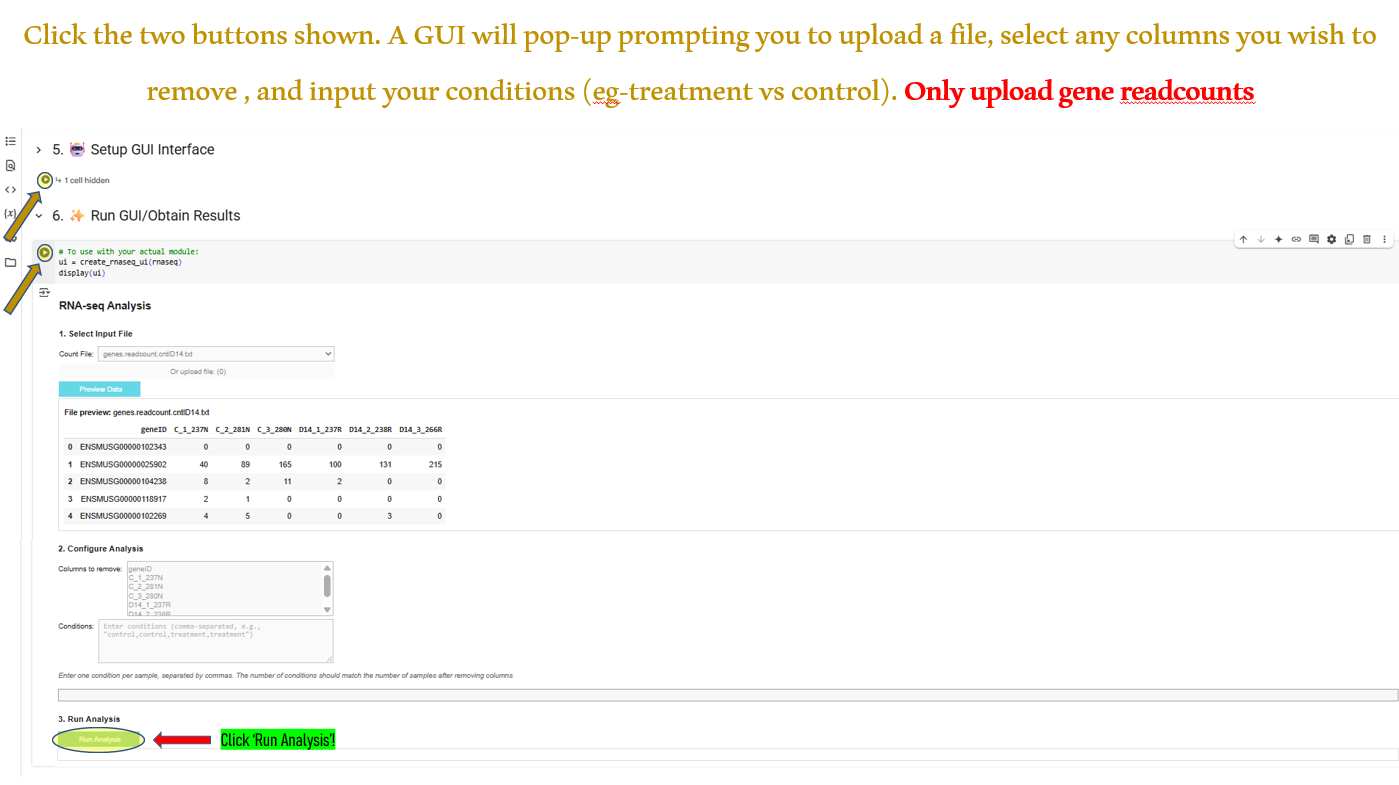


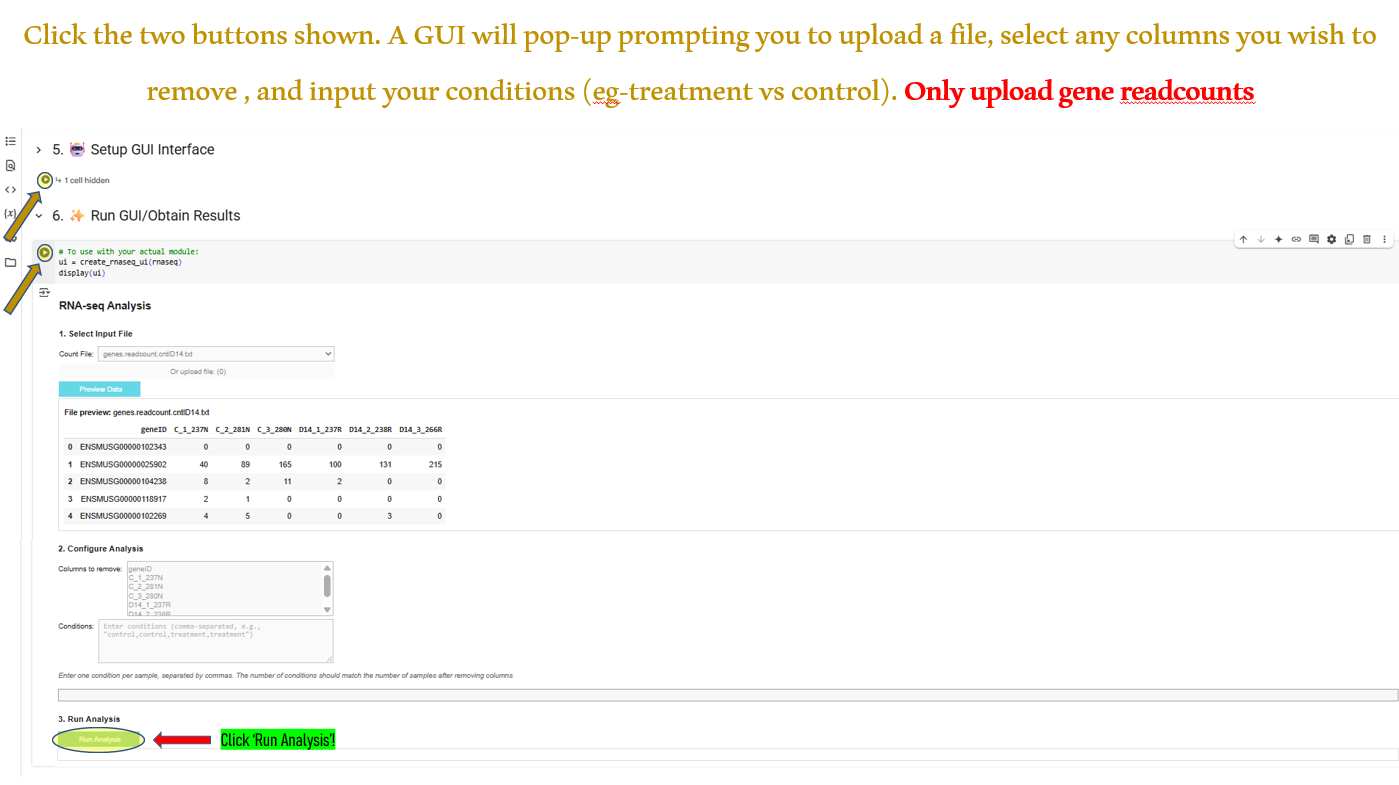

Image encoded successfully. First 50 chars: iVBORw0KGgoAAAANSUhEUgAABXcAAAMRCAYAAACnK4USAAAAAX...

Image encoded successfully. Encoding 

AADEGEuwAAAAAAAAAw5Ej/H+Farjz7EKjJAAAAAElFTkSuQmCC...


In [ ]:
import base64
from IPython.display import Image, display
from google.colab import files
import io

# Upload an image
uploaded = files.upload()

# Get the file name and content of the uploaded image
file_name = list(uploaded.keys())[0]
image_data = uploaded[file_name]

# Encode the image as base64
encoded = base64.b64encode(image_data).decode('ascii')
image_src = f'data:image/jpeg;base64,{encoded}'

# Display the image
display(Image(data=image_data, width=500))

# Store the base64 string in a variable for later use
# This is what makes the image "stick" to the notebook
image_variable = f'data:image/jpeg;base64,{encoded}'

# You can display it again later with:
display(Image(url=image_variable, width=500))

# Print a small portion of the encoded string to confirm it worked
print(f"Image encoded successfully. First 50 chars: {encoded[:50]}...")
print(f"\nImage encoded successfully. Encoding \n\n{encoded[-50:]}...")

In [ ]:
from google.colab import files

uploaded = files.upload()

for filename in uploaded.keys():
    print(f"Uploaded file: {filename}")

In [ ]:
# Run demo if executed directly
if __name__ == "__main__":

    # Create the analysis object
    rnaseq = RNASeqAnalysis()

    count_file = list(uploaded.keys())[0]

    # Run the analysis
    result = rnaseq.run_rnaseq_analysis(
        # count_file = "genes.readcount.cntlD14.txt",
        count_file = count_file,
        columns_to_delete = StrVector(["C_3_280N"]),  # R character vector
        conditions = StrVector(["control", "control", "treatment", "treatment", "treatment"])  # R character vector
    )

    print("Analysis complete with the following results:")
    # print(f"Total genes analyzed: {result[0]}")
    # print(f"Significantly differentially expressed genes: {result[1]}")
    print(f"Total genes analyzed: {result}")

📝 Created RNA-seq R analysis script: scripts/rnaseq_analysis.R


Saving 7 x 7 in image


Saving 7 x 7 in image
Analysis complete with the following results:
Total genes analyzed: $total_genes
[1] 27016

$sig_genes
[1] 1572

$top_genes
                    gene  baseMean log2FoldChange     lfcSE      stat
25081 ENSMUSG00000116812  224.5939       5.383770 0.4676775 11.511714
8067  ENSMUSG00000032656 5666.2648       1.674123 0.1620593 10.330306
11582 ENSMUSG00000044471 9688.9557       1.490987 0.1596143  9.341189
24222 ENSMUSG00000113202 1981.8355       1.703112 0.1849163  9.210174
16830 ENSMUSG00000079363 1505.8312       2.920850 0.3263440  8.950218
12443 ENSMUSG00000048758 6040.8053       2.934697 0.3331575  8.808739
5425  ENSMUSG00000027381  791.7739       1.815716 0.2199795  8.254023
22949 ENSMUSG00000108560  350.4330       2.707320 0.3315628  8.165330
26851        XLOC_085861 1551.2978       2.032087 0.2512378  8.088304
26933        XLOC_116280  168.0926       4.104998 0.5109450  8.034129
22945 ENSMUSG00000108542  195.7211       2.888444 0.3611115  7.998759
3871  ENSMUSG0

In [ ]:
import os
import sys
import subprocess
import time

def run_command(cmd, desc=None):
    """Run a command and print its output"""
    if desc:
        print(f"\n{desc}")

    print(f"Running: {cmd}")
    process = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)

    # Print output in real-time
    for line in iter(process.stdout.readline, b''):
        print(line.decode('utf-8').rstrip())

    process.wait()
    return process.returncode == 0

def fix_r_environment():
    """Complete rebuild of the R environment to fix package compatibility issues"""
    print("🔄 Starting R environment rebuild...")

    # 1. Remove existing R installation
    run_command("sudo apt-get remove -y r-base r-base-dev", "1️⃣ Removing existing R installation")
    run_command("sudo apt-get autoremove -y", "Cleaning up")

    # 2. Install the latest R version
    run_command("sudo apt-key adv --keyserver keyserver.ubuntu.com --recv-keys E298A3A825C0D65DFD57CBB651716619E084DAB9",
                "2️⃣ Adding R repository key")
    run_command("sudo add-apt-repository 'deb https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/'",
                "Adding CRAN repository")
    run_command("sudo apt-get update", "Updating package lists")
    run_command("sudo apt-get install -y r-base r-base-dev", "Installing R")

    # 3. Check R version
    run_command("R --version | head -n 1", "3️⃣ Checking R version")

    # 4. Install critical system dependencies
    run_command("sudo apt-get install -y --no-install-recommends libfreetype6-dev libpng-dev libtiff5-dev libjpeg-dev",
                "4️⃣ Installing system dependencies")

    # 5. Install essential R packages with careful sequencing
    print("\n5️⃣ Installing essential R packages...")

    # Install base packages first
    r_install_base = """
    options(repos = c(CRAN = "https://cloud.r-project.org"))
    options(Ncpus = 2)
    install.packages(c("grid", "methods", "utils", "stats", "grDevices"))
    """
    with open("install_base.R", "w") as f:
        f.write(r_install_base)
    run_command("Rscript install_base.R", "Installing base packages")

    # Then install ggplot2 and dependencies
    r_install_ggplot = """
    options(repos = c(CRAN = "https://cloud.r-project.org"))
    options(Ncpus = 2)
    install.packages(c("rlang", "scales", "tibble", "ggplot2"), dependencies=TRUE)
    """
    with open("install_ggplot.R", "w") as f:
        f.write(r_install_ggplot)
    run_command("Rscript install_ggplot.R", "Installing ggplot2 and dependencies")

    # Then install tidyverse
    r_install_tidyverse = """
    options(repos = c(CRAN = "https://cloud.r-project.org"))
    options(Ncpus = 2)
    install.packages("tidyverse", dependencies=TRUE)
    """
    with open("install_tidyverse.R", "w") as f:
        f.write(r_install_tidyverse)
    run_command("Rscript install_tidyverse.R", "Installing tidyverse")

    # Install additional CRAN packages
    r_install_cran = """
    options(repos = c(CRAN = "https://cloud.r-project.org"))
    options(Ncpus = 2)
    install.packages(c("pheatmap", "here", "BiocManager"), dependencies=TRUE)
    """
    with open("install_cran.R", "w") as f:
        f.write(r_install_cran)
    run_command("Rscript install_cran.R", "Installing additional CRAN packages")

    # Install Bioconductor packages
    r_install_bioc = """
    options(repos = c(CRAN = "https://cloud.r-project.org"))
    if (!requireNamespace("BiocManager", quietly = TRUE))
        install.packages("BiocManager")
    BiocManager::install(version="3.16", ask=FALSE)
    BiocManager::install(c("DESeq2", "org.Mm.eg.db", "clusterProfiler", "biomaRt", "enrichplot"),
                        ask=FALSE, update=FALSE)
    """
    with open("install_bioc.R", "w") as f:
        f.write(r_install_bioc)
    run_command("Rscript install_bioc.R", "Installing Bioconductor packages")

    # 6. Verify installations
    r_verify = """
    packages <- c("tidyverse", "ggplot2", "pheatmap", "here", "BiocManager",
                 "DESeq2", "org.Mm.eg.db", "clusterProfiler", "biomaRt", "enrichplot")

    results <- data.frame(
        Package = packages,
        Installed = sapply(packages, function(x) requireNamespace(x, quietly = TRUE)),
        Version = sapply(packages, function(x)
            if(requireNamespace(x, quietly = TRUE))
                as.character(packageVersion(x))
            else "Not installed")
    )

    print(results)

    # Test loading critical packages
    cat("\nTesting package loading:\n")
    tryCatch({
        library(tidyverse)
        cat("✓ tidyverse loaded successfully\n")
    }, error = function(e) {
        cat("✗ tidyverse failed to load:", conditionMessage(e), "\n")
    })

    tryCatch({
        library(ggplot2)
        cat("✓ ggplot2 loaded successfully\n")
    }, error = function(e) {
        cat("✗ ggplot2 failed to load:", conditionMessage(e), "\n")
    })
    """

    with open("verify_packages.R", "w") as f:
        f.write(r_verify)
    run_command("Rscript verify_packages.R", "6️⃣ Verifying package installations")

    # Clean up temporary files
    for file in ["install_base.R", "install_ggplot.R", "install_tidyverse.R",
                "install_cran.R", "install_bioc.R", "verify_packages.R"]:
        if os.path.exists(file):
            os.remove(file)

    print("\n✅ R environment rebuild complete!")
    print("If you still see issues, try restarting your Colab runtime and running your analysis again.")

if __name__ == "__main__":
    fix_r_environment()

🔄 Starting R environment rebuild...

1️⃣ Removing existing R installation
Running: sudo apt-get remove -y r-base r-base-dev
Reading package lists...
Building dependency tree...
Reading state information...
The following packages were automatically installed and are no longer required:
  libbz2-dev libreadline-dev
Use 'sudo apt autoremove' to remove them.
The following packages will be REMOVED:
  r-base r-base-dev
0 upgraded, 0 newly installed, 2 to remove and 38 not upgraded.
After this operation, 81.9 kB disk space will be freed.
(Reading database ... 126105 files and directories currently installed.)
Removing r-base (4.5.0-3.2204.0) ...
Removing r-base-dev (4.5.0-3.2204.0) ...

Cleaning up
Running: sudo apt-get autoremove -y
Reading package lists...
Building dependency tree...
Reading state information...
The following packages will be REMOVED:
  libbz2-dev libreadline-dev
0 upgraded, 0 newly installed, 2 to remove and 38 not upgraded.
After this operation, 900 kB disk space will be 